In [2]:
#Import Packages and Libraries
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.optimize as optimize
idx = pd.IndexSlice
from math import log, log10, exp, e, pow, sqrt
from scipy.optimize import root
import scipy.integrate as integrate
import scipy
pd.set_option('display.max_rows', None)

#Adjusts window size for Jupyter notebook to fill screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


#ASSUMPTIONS
MemCost = 2000 #USD per m2
MemLife = 5 #lifetime of membrane
OnStreamFac = 0.9 
MFenergyeff = 0.8 #Factor used to account for mechanical inefficiency and power factor 
Energycost = 0.078 #USD/kWh
#Disc speed of 1200 rpm (Figure 7 used to estimate filtration energy)

#Build dataframes for output data
colsS = ['SugRec','F1', 'F2', 'F3', 'F4', 'F5','F6','F7','F8'] #Stream Flowrates L/hr
dfS = pd.DataFrame(data=np.zeros((1, len(colsS))), columns = colsS)

colsC = ['SugRec','C1','C2','C3','C4','C5','C6','C7','C8'] #Sugar concentration g/L
dfC = pd.DataFrame(data=np.zeros((1, len(colsC))), columns = colsC)

colsP = ['SugRec','VR2', 'ISfeed', 'ISop', 'ISF5', 'ISop2', 'LMH', 'F4'] #IS concentration wt%
dfP = pd.DataFrame(data=np.zeros((1, len(colsP))), columns = colsP)

colsPT = ['F4','SugRec_6%','SugRec_9%', 'SugRec_12%','SugRec_15%'] #for plot
dfPT = pd.DataFrame(data=np.zeros((1, len(colsPT))), columns = colsPT)

colsPT2 = ['SugRec_6%','SugRec_9%', 'SugRec_12%','SugRec_15%','Area_6%','Area_9%','Area_12%','Area_15%'] #for plot 
dfPT2 = pd.DataFrame(data=np.zeros((1, len(colsPT2))), columns = colsPT2)

colsPT3 = ['SugRec_6%','SugRec_9%', 'SugRec_12%','SugRec_15%','EvapCost_6%','EvapCost_9%','EvapCost_12%','EvapCost_15%'] #for plot
dfPT3 = pd.DataFrame(data=np.zeros((1, len(colsPT3))), columns = colsPT3)

colsPT4 = ['SugRec_6%','SugRec_9%', 'SugRec_12%','SugRec_15%','MemMatCost_6%','MemMatCost_9%','MemMatCost_12%','MemMatCost_15%'] #fo
dfPT4 = pd.DataFrame(data=np.zeros((1, len(colsPT4))), columns = colsPT4)

colsPT5 = ['SugRec_6%','SugRec_9%', 'SugRec_12%','SugRec_15%','MFCost_6%','MFCost_9%','MFCost_12%','MFCost_15%'] #for plot
dfPT5 = pd.DataFrame(data=np.zeros((1, len(colsPT5))), columns = colsPT5)

colsPT6 = ['SugRec_6%','SugRec_9%', 'SugRec_12%','SugRec_15%','ProcessOPEX_6%','ProcessOPEX_9%','ProcessOPEX_12%','ProcessOPEX_15%'] #for plot
dfPT6 = pd.DataFrame(data=np.zeros((1, len(colsPT6))), columns = colsPT6)

colsPT7 = ['SugRec_6%','SugRec_9%', 'SugRec_12%','SugRec_15%','MFelec_6%','MFelec_9%','MFelec_12%','MFelec_15%'] #for plot
dfPT7 = pd.DataFrame(data=np.zeros((1, len(colsPT7))), columns = colsPT7)

colsPT8 = ['SugRec_6%','SugRec_9%', 'SugRec_12%','SugRec_15%','MFclean_6%','MFclean_9%','MFclean_12%','MFclean_15%'] #for plot
dfPT8 = pd.DataFrame(data=np.zeros((1, len(colsPT8))), columns = colsPT8)

colsPT9 = ['SugRec_6%','SugRec_9%', 'SugRec_12%','SugRec_15%','MFwatercost_6%','MFwatercost_9%','MFwatercost_12%','MFwatercost_15%'] #for plot
dfPT9 = pd.DataFrame(data=np.zeros((1, len(colsPT9))), columns = colsPT9)

colsPT10 = ['SugRec_6%','SugRec_9%', 'SugRec_12%','SugRec_15%','MFmixCost_6%','MFmixCost_9%','MFmixCost_12%','MFmixCost_15%'] #for plot
dfPT10 = pd.DataFrame(data=np.zeros((1, len(colsPT10))), columns = colsPT10)


#INPUTS
Feedflow = 10000  #L/hr (F1)                       
ISfeed = 3 #wt% - insoluble solids content in feed (F1)         
C1 = 100 #g/L sugar concentration in F1
C4 = 0 #g/L sugar in wash feed (F4)
F4 = 20000 #flow rate of wash feed
ISop = 6 #wt% - insoluble solids content in the retentate streams 
SugRec = 0

#df = pd.DataFrame([[SugRec, F4, ISop]])
colsPT = ['SugRec','F4','ISop'] #for plot
dfPT = pd.DataFrame(data=np.zeros((0, len(colsPT))), columns = colsPT)


import itertools
for ISop, WaterFlow in itertools.product(range(60,150,1), range(200,20000,100)):

    ISop = ISop/10
    F4 = WaterFlow
#Calculations
    VR1 =  (ISop-ISfeed)/ISop #Volume recovery achieved in first stage based on desired IS content in retentate 

#Begin iteration across F4 (1-50,000 L/hr)
#    for WaterFlow in range(1,20001,100):
#        F4 = WaterFlow
    
#Mass balance to determine stream flowrates

    F1 = Feedflow #L/hr feed flow rate
    F2 = F1*VR1 #Permeate flow rate set by volume recovery
    F3 = F1 - F2 #Mass balance over MF stage 1
    F5 = F3+F4 #Mixing of wash water with MF stage 1 retentate 

    ISop2 = ISop #Setting the desired insoluble content in the MF stage 2 retentate equal to the IS content in stage 1 retentate 

    C2 = C1 #Assumes no change in concentration of sugars across MF membrane
    C3 = C1 #Assumes no change in concentration of sugars across MF membrane

    ISF5 = (ISop*F3)/ (F3+F4) #Calculates the new IS concentration after dilution with wash water
    VR2 =  (ISop2-ISF5)/ISop2 #calculates the MF stage 2 recovery based on desired IS content in retenate 

    F7 = F5*VR2 #Permeate flow in Stage 2 set by volume recovery
    F8 = F2 + F7 #Combining the permeate flows
    F6 = F5 - F7 #Mass balance over MF stage 2
    
    # Estimating the sugar lost due to entrainment during washing 
    CakeF3 = ISop/100*F3 #Mass flow of insoluble solids
    LCF3 = CakeF3 *(1-ISop/100) #estimated total liquid entrained with insoluble solids
    W = F4 / LCF3 #wash ratio (wash water / liquid flow of cake) REF: Sievers, David A., Ling Tao, and Daniel J. Schell., Bioresource technology 167 (2014): 291-296.
    CakeC = C3 * 1.5 * exp(-1.21 * W) #Concentration of sugars in entrained fraction REF: Sievers, David A., Ling Tao, and Daniel J. Schell., Bioresource technology 167 (2014): 291-296.
    SF5 = F3*C3/1000-CakeF3*CakeC/1000 #Sugar flow rate in F5 after dilution accounting for entrainment 
    ISF5 = F3*C3/1000 #Ideal sugar flow rate in F5 after dilution without accounting for entrainment
    RF5 = SF5/ISF5 #Recovery of sugars during washing
    C5 = RF5 * F3 * C3 / F5 #New C5 concentration of sugars accounting for entrainment 
    
    C6 = C5 #Assumes no change in concentration of sugars across MF membrane
    C7 = C5 #Assumes no change in concentration of sugars across MF membrane
    C8 = (F2*C2 + F7*C7)/(F2+F7) #calculates concentration of sugars after mixing the two permeate streams 

    SugRec = F8*C8 / (F1*C1) #Total sugar recovery from two-stage MF process
    
    #OPEX estimate
    LMH = -0.425*(ISop)**2 - 0.44*ISop +132.33 #Estimates flux of MF units based on IS content in retentate (Figure 3 of main text)
    
    Area1 = F2/LMH #Area needed for MF stage 1
    Area2 = F7/LMH #Area needed for MF stage 2
    TotArea = Area1 + Area2 #Total membrane needed for stage 1+2
    
    MemMatCost = MemCost / MemLife / OnStreamFac / 365 / 24 / (F8*C8/1000) * TotArea #Membrane material replacement cost on a kg sugar basis (units of $/kg sugar)
    
    MFenergyW = 0.1188*exp(0.2024*ISop) /0.032 #Watts of energy associated with disc filtration (Figure 7 of main text at 1200 rpm) per m2
    MFenergykWkg = MFenergyW/ 1000 / LMH / C8 *1000 / MFenergyeff #conversion to kWh/kg of sugar
    MFenergyMJkg = MFenergyW / 1000 / LMH / C8 *1000 / MFenergyeff*3.6 #conversion to MJ/kg of sugar
    
    MFenergycost = MFenergykWkg*Energycost #USD per kg sugar associated with filtration electrical energy consumption
    MFcost = MFenergycost + MemMatCost #Total MF operating cost including material replacement costs and energy cost
    MFcostm3 = MFcost*C8 #MF cost on a m3 basis
    
    MFenergykWm3 = MFenergyW / 1000 / LMH / C8 #MF energy with units of kW/m3
    MFelec = MFenergycost #USD per kg sugar associated with filtration electrical energy consumption
    
    EvapCost = 0.0003 * (C8/10/100)**-1.493 #Utility cost in USD/kg glucose
    
    MFwatercost = F4 * 4 / 3.8 / 1000 / (F8*C8/1000) #https://www.energy.gov/sites/prod/files/2017/10/f38/water_wastewater_escalation_rate_study.pdf
    
    MFmixCost = .2 * 365 * 24 * .9 / 1000 * 365 *24* .9 * Energycost / (C8*F8 / 1000 * 365 * 24 * .9)
    
    ProcessOPEX = EvapCost + MFcost + MFwatercost + MFmixCost #Estimated OPEX 
    
    MFclean = .2 * ProcessOPEX /.8  #https://www.mdpi.com/2077-0375/11/2/131
    
    ProcessOPEX = ProcessOPEX  + MFclean
    
    F4 = F4 / 1000 # convert to m3 per hr
    
    #dfP.loc[idx[WaterFlow-1],idx['SugRec']] = SugRec
    #dfP.loc[idx[WaterFlow-1],idx['F4']] = F4
    #dfP.loc[idx[WaterFlow-1],idx['ISop']] = ISop
    
    dfPT = pd.concat([dfPT, pd.DataFrame([[SugRec,  F4,  ISop, ProcessOPEX]])])
   # df = pd.concat([df, pd.DataFrame([[SugRec,  F4,  ISop]])]

C:\Users\psaboe\AppData\Local\Temp\1\ipykernel_8600\4100382352.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


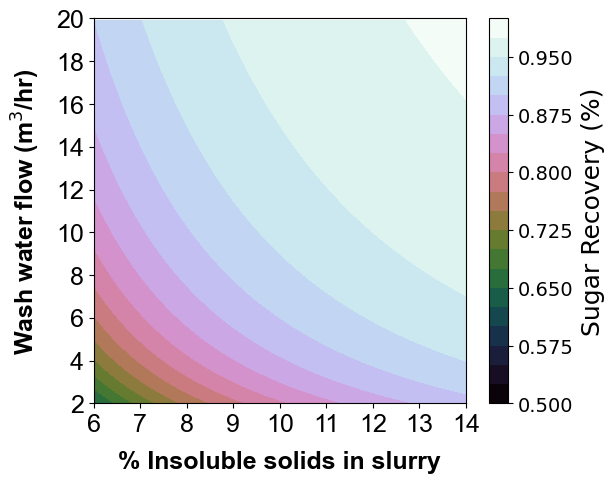

In [3]:
#plt.tricontour(x,y, z)
from matplotlib import ticker, cm
from matplotlib import ticker, cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,sharey=False,sharex=False,figsize=(6,5))

x = dfPT.iloc[:,5]
y = dfPT.iloc[:,4]
z = dfPT.iloc[:,3]


tcf = ax.tricontourf(x, y, z ,20, cmap = "cubehelix")

#plt.clabel(tcf, inline=1, fontsize=10) 

cb = plt.colorbar(tcf)
cb.set_label("Sugar Recovery (%)", labelpad=5, size=18)

cb.ax.tick_params(labelsize=14)

    
plt.xlabel("% Insoluble solids in slurry",fontsize=18,fontname="Arial",weight='bold',labelpad=10)
plt.ylabel("Wash water flow (m$^{3}$/hr)",fontsize=18,fontname="Arial",weight='bold',labelpad=10)

           
plt.xlim([6, 14])
plt.ylim([2 ,20 ])

for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    
for tick in ax.get_xticklabels():
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontsize(18)



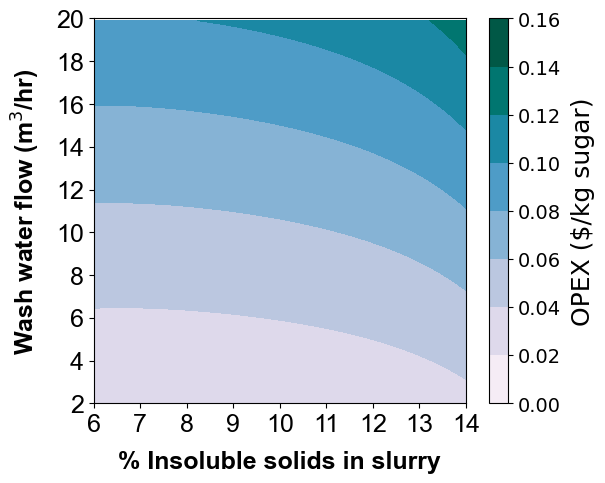

In [4]:
#plt.tricontour(x,y, z)
from matplotlib import ticker, cm
from matplotlib import ticker, cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,sharey=False,sharex=False,figsize=(6,5))

x = dfPT.iloc[:,5]
y = dfPT.iloc[:,4]
z = dfPT.iloc[:,6]


tcf = ax.tricontourf(x, y, z ,7, cmap = "PuBuGn")

#plt.clabel(tcf, inline=1, fontsize=10) 
cb = plt.colorbar(tcf)
cb.set_label("OPEX ($/kg sugar)", labelpad=7, size=18)

cb.ax.tick_params(labelsize=14)


plt.xlabel("% Insoluble solids in slurry",fontsize=18,fontname="Arial",weight='bold',labelpad=10)
plt.ylabel("Wash water flow (m$^{3}$/hr)",fontsize=18,fontname="Arial",weight='bold',labelpad=10)

           
plt.xlim([6, 14])
plt.ylim([2 ,20 ])

for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    
for tick in ax.get_xticklabels():
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontsize(18)
